<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/gpt_conceptnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installation

In [1]:
!pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=56525c63ad7ab3f361dd3ac420366909e6bc7febde1550a0da969973e15d59c4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5

In [24]:
import open_clip
import clip
from torchvision.datasets import CIFAR10
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# preprocessing

In [3]:
CLASS_SIM_CUTOFF = 0.85
OTHER_SIM_CUTOFF = 0.9
MAX_LEN = 30

PRINT_PROB = 0.2
save_name = "data/gpt_cifar10_filtered_new.txt"

In [4]:
def remove_too_long(concepts, max_len, print_prob=0):
    new_concepts = []
    for concept in concepts:
        if len(concept) <= max_len:
            new_concepts.append(concept)
        else:
            if random.random()<print_prob:
                print(len(concept), concept)
    print(len(concepts), len(new_concepts))
    return new_concepts

In [5]:
def filter_too_similar(concepts, sim_cutoff, device="cuda", print_prob=0):

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    concept_features = mpnet_model.encode(concepts)

    dot_prods_m = concept_features @ concept_features.T
    dot_prods_c = _clip_dot_prods(concepts, concepts)

    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(concepts)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if i not in to_delete and j not in to_delete:
                    to_print = random.random() < print_prob
                    #Deletes the concept with lower average similarity to other concepts - idea is to keep more general concepts
                    if np.sum(dot_prods[i]) < np.sum(dot_prods[j]):
                        to_delete.append(i)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[i]))
                    else:
                        to_delete.append(j)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[j]))

    to_delete = sorted(to_delete)[::-1]
    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [6]:
def filter_too_similar_to_cls(concepts, classes, sim_cutoff, device="cuda", print_prob=0):
    #first check simple text matches
    print(len(concepts))
    concepts = list(concepts)
    concepts = sorted(concepts)

    for cls in classes:
        for prefix in ["", "a ", "A ", "an ", "An ", "the ", "The "]:
            try:
                concepts.remove(prefix+cls)
                if random.random()<print_prob:
                    print("Class:{} - Deleting {}".format(cls, prefix+cls))
            except(ValueError):
                pass
        try:
            concepts.remove(cls.upper())
        except(ValueError):
            pass
        try:
            concepts.remove(cls[0].upper()+cls[1:])
        except(ValueError):
            pass
    print(len(concepts))

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    class_features_m = mpnet_model.encode(classes)
    concept_features_m = mpnet_model.encode(concepts)
    dot_prods_m = class_features_m @ concept_features_m.T
    dot_prods_c = _clip_dot_prods(classes, concepts)
    #weighted since mpnet has highger variance
    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(classes)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if j not in to_delete:
                    to_delete.append(j)
                    if random.random()<print_prob:
                        print("Class:{} - Concept:{}, sim:{:.3f} - Deleting {}".format(classes[i], concepts[j], dot_prods[i,j], concepts[j]))
                        print("".format(concepts[j]))

    to_delete = sorted(to_delete)[::-1]

    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [7]:
def _clip_dot_prods(list1, list2, device="cuda", clip_name="ViT-B/16", batch_size=500):
    "Returns: numpy array with dot products"
    clip_model, _ = clip.load(clip_name, device=device)
    text1 = clip.tokenize(list1).to(device)
    text2 = clip.tokenize(list2).to(device)

    features1 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text1)/batch_size)):
            features1.append(clip_model.encode_text(text1[batch_size*i:batch_size*(i+1)]))
        features1 = torch.cat(features1, dim=0)
        features1 /= features1.norm(dim=1, keepdim=True)

    features2 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text2)/batch_size)):
            features2.append(clip_model.encode_text(text2[batch_size*i:batch_size*(i+1)]))
        features2 = torch.cat(features2, dim=0)
        features2 /= features2.norm(dim=1, keepdim=True)

    dot_prods = features1 @ features2.T
    return dot_prods.cpu().numpy()

In [8]:
cls_file = "data/cifar10_classes.txt"

with open(cls_file, 'r') as f:
    classes = f.read().split('\n')

In [14]:
with open("data/gpt_cifar10_concepts.txt", 'r') as f:
    concepts = f.read().lower().split('\n')

In [16]:
concepts = remove_too_long(concepts, MAX_LEN, PRINT_PROB)

125 125


In [17]:
concepts = filter_too_similar_to_cls(concepts, classes, CLASS_SIM_CUTOFF, print_prob=PRINT_PROB)

125
125


100%|███████████████████████████████████████| 335M/335M [00:10<00:00, 33.5MiB/s]


Class:automobile - Concept:vehicle, sim:0.904 - Deleting vehicle

Class:bird - Concept:avian, sim:0.882 - Deleting avian

110


In [18]:
concepts = filter_too_similar(concepts, OTHER_SIM_CUTOFF, print_prob=PRINT_PROB)

 -  , sim:1.0000 - Deleting 
 -  , sim:1.0000 - Deleting 
ears - ears , sim:1.0000 - Deleting ears
highways - roads , sim:0.9089 - Deleting highways
homes - homes , sim:1.0010 - Deleting homes
paws - paws , sim:1.0000 - Deleting paws
wheels - wheels , sim:0.9995 - Deleting wheels
77


In [20]:
with open(save_name, "w") as f:
    f.write(concepts[0])
    for concept in concepts[1:]:
        f.write("\n" + concept)

# inference

In [21]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

In [22]:
clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [25]:
cifar10 = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 40061520.81it/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache


вместо этого шага представлять каждое фото в датасете в jpg и загружать их в отдельную директорию (сделать потом, как напишу классификатор)

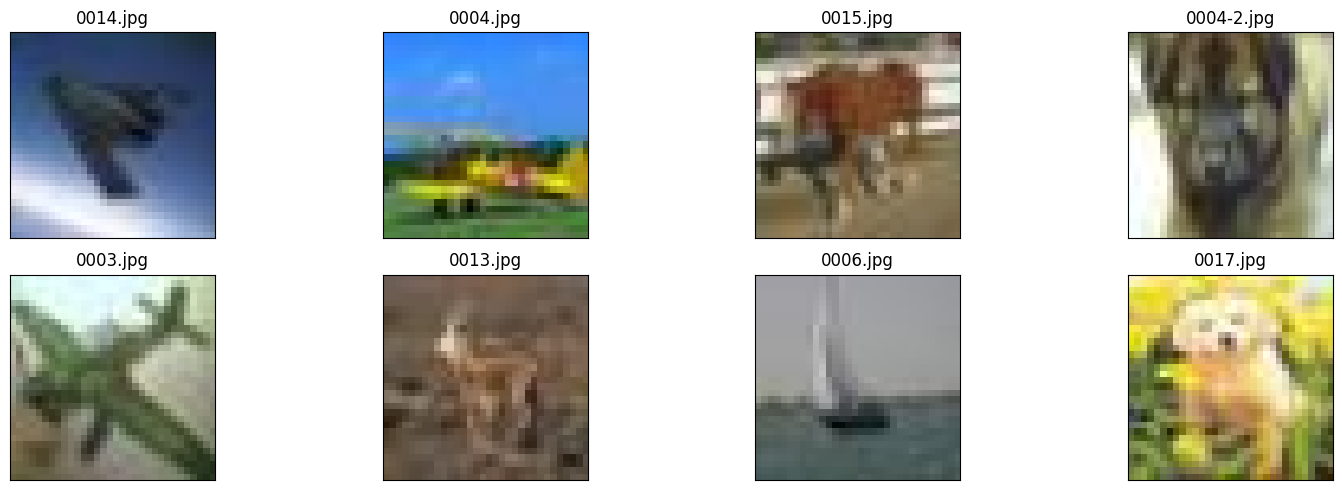

In [26]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [27]:
image_input = torch.tensor(np.stack(images))

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [29]:
text_descriptions = []

with open("data/gpt_cifar10_filtered_new.txt", "r") as file:
    for line in file:
        text_descriptions.append(line.strip())

print(text_descriptions)

['airport', 'amphibian', 'antlers', 'beak', 'bird feeders', 'body', 'cab', 'cargo bed', 'clouds', 'construction sites', 'creature', 'deck', 'dog parks', 'ears', 'engines', 'equestrian events', 'eyes', 'farms', 'feathers', 'forests', 'fur', 'fuselage', 'gas stations', 'harbors', 'headlights', 'herbivore', 'homes', 'hooves', 'hull', 'lakes', 'landing gear', 'leashes', 'legs', 'lily pads', 'litter boxes', 'livestock', 'machine', 'mammal', 'mane', 'mast', 'meadows', 'mirrors', 'muscular body', 'nests', 'oceans', 'parking lots,', 'parks', 'pastures', 'paws', 'pet beds', 'ponds', 'portholes', 'ports', 'propellers', 'rivers', 'roads', 'runway', 'skin texture', 'sky', 'snout', 'stables', 'streets', 'tail', 'transportation', 'trees', 'warehouses', 'watercraft', 'webbed feet', 'wetlands', 'wheels', 'whiskers', 'wildlife reserves', 'windows', 'windshield', 'wings', 'yards']


In [30]:
text_tokens = tokenizer.tokenize(text_descriptions)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

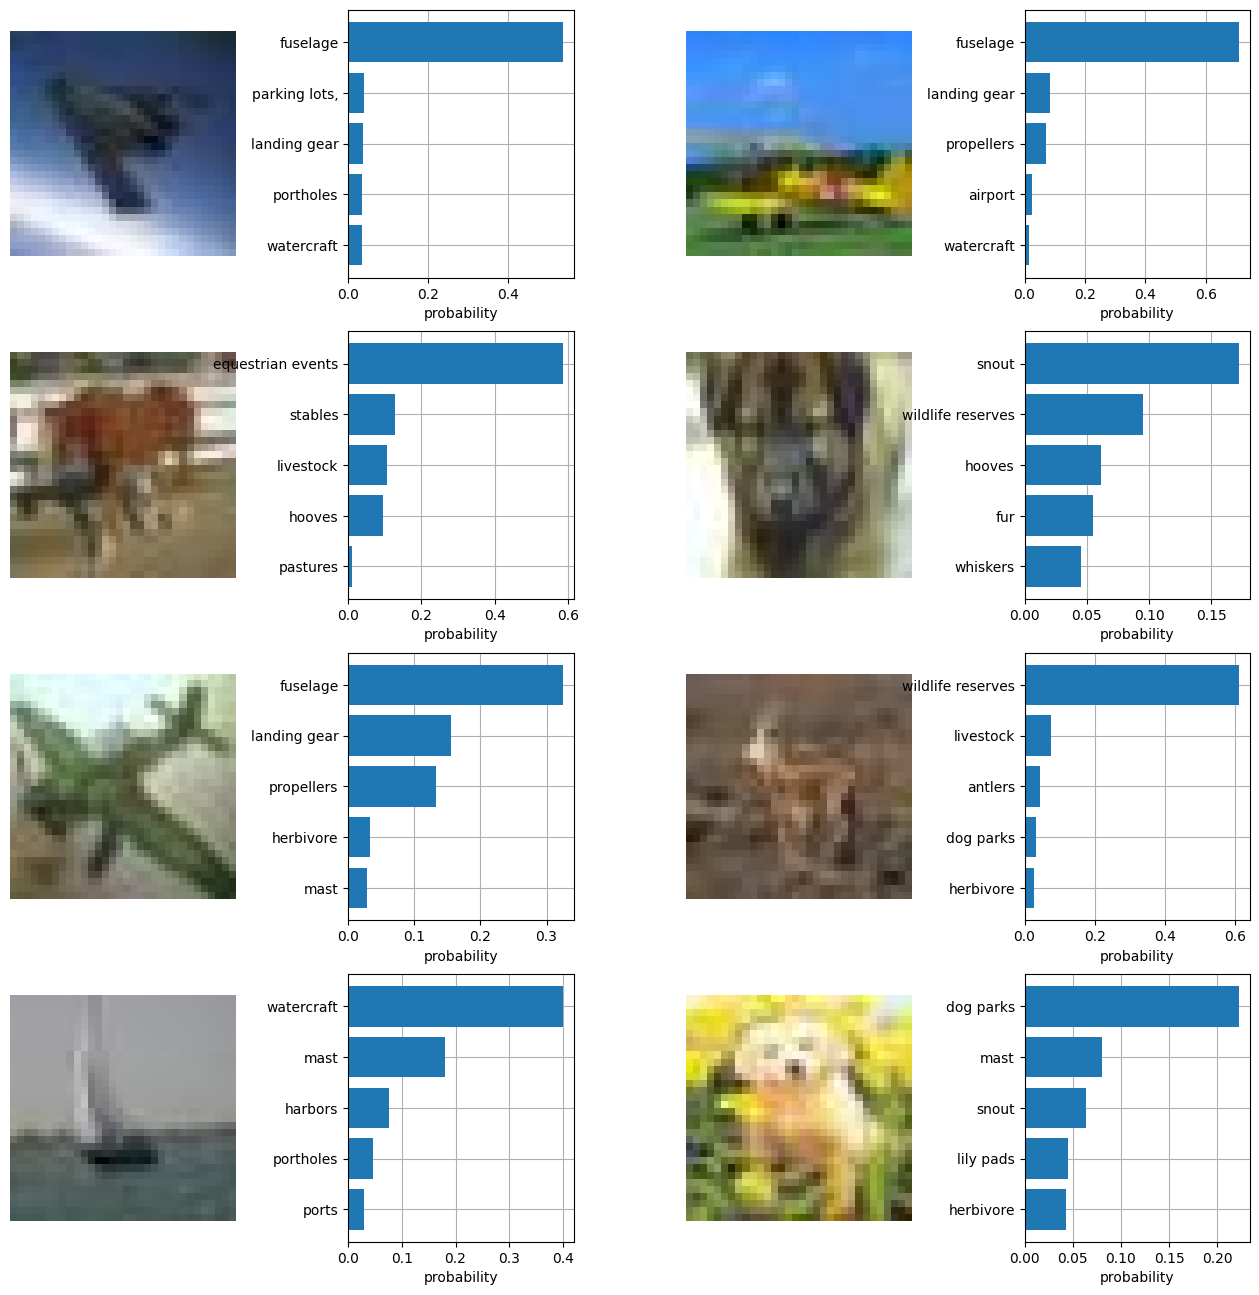

In [31]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Mix of GPT and ConceptNet

In [33]:
data = data2 = "";

with open('data/gpt_cifar10_filtered_new.txt') as fp:
    data = fp.read()

with open('data/conceptnet_cifar10_filtered_new.txt') as fp:
    data2 = fp.read()

data += "\n"
data += data2

with open ('data/gpt_and_conceptnet_cifar10.txt', 'w') as fp:
    fp.write(data)

In [36]:
with open ('data/gpt_and_conceptnet_cifar10.txt', 'r') as f:
    concepts = f.read().split('\n')

In [38]:
concepts = remove_too_long(concepts, MAX_LEN, PRINT_PROB)

196 196


In [39]:
concepts = filter_too_similar_to_cls(concepts, classes, CLASS_SIM_CUTOFF, print_prob=PRINT_PROB)

196
196
196


In [40]:
concepts = filter_too_similar(concepts, OTHER_SIM_CUTOFF, print_prob=PRINT_PROB)

deck - deck , sim:1.0010 - Deleting deck
mammal - mammal , sim:1.0010 - Deleting mammal
182


In [41]:
with open("data/gpt_conceptnet_cifar10_filtered.txt", "w") as f:
    f.write(concepts[0])
    for concept in concepts[1:]:
        f.write("\n" + concept)

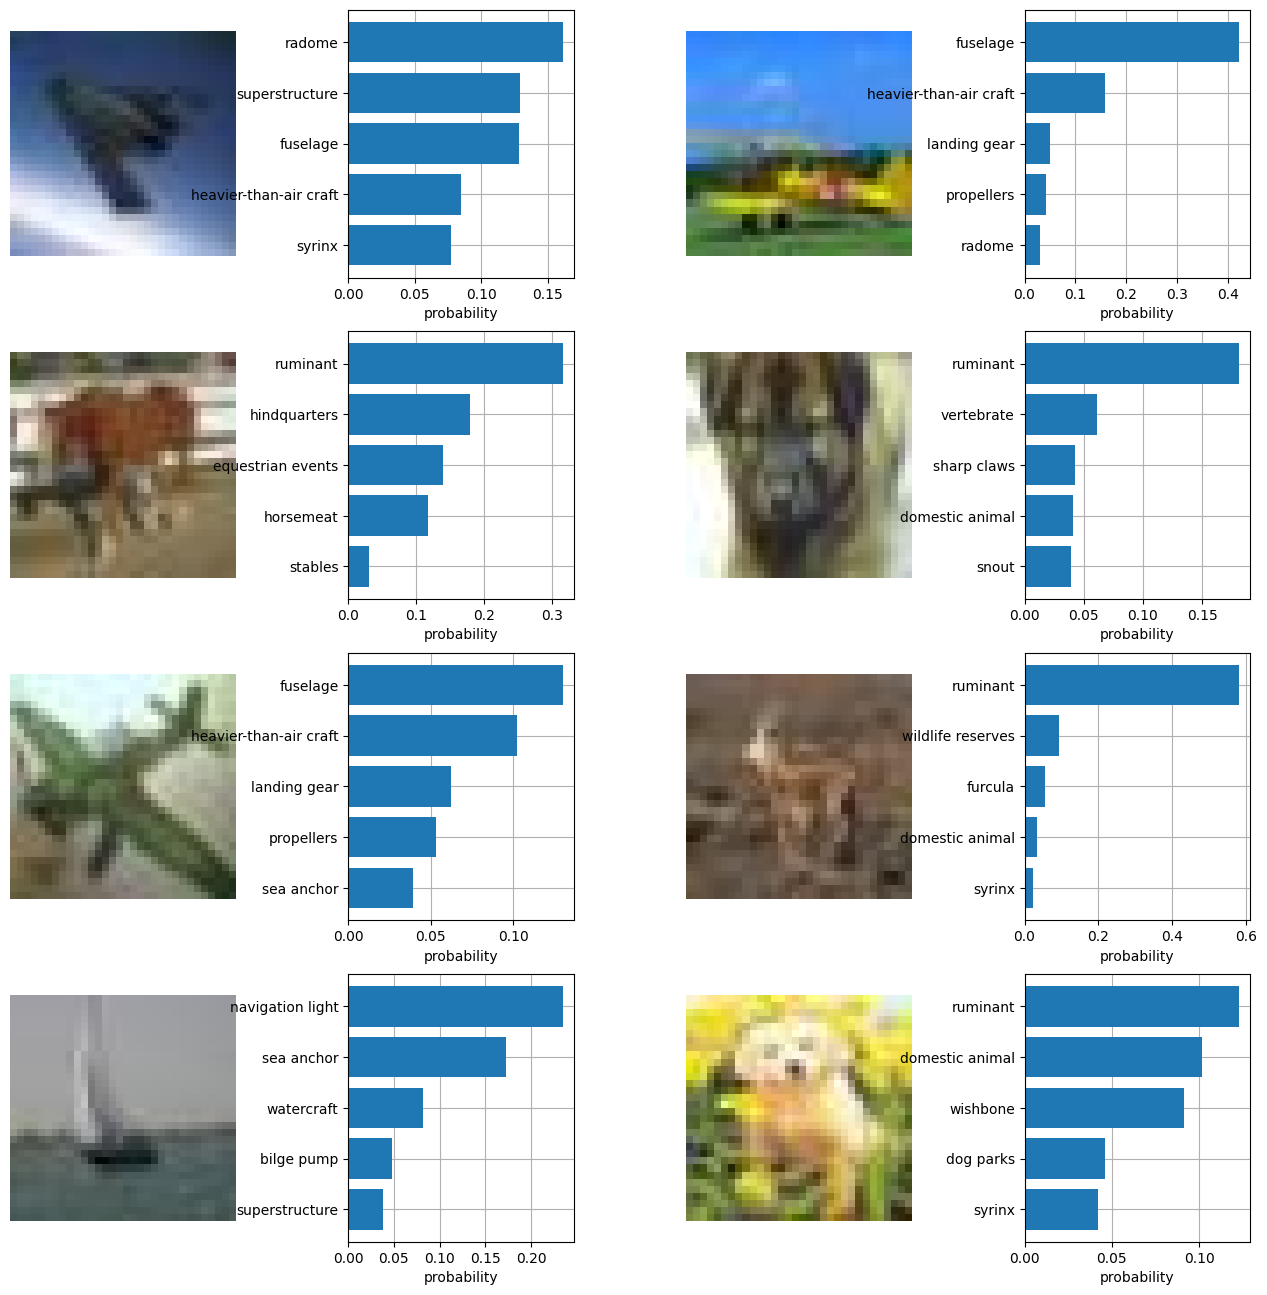

In [42]:
text_descriptions = []

with open("data/gpt_conceptnet_cifar10_filtered.txt", "r") as file:
    for line in file:
        text_descriptions.append(line.strip())


text_tokens = tokenizer.tokenize(text_descriptions)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)


plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()